In [32]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import scores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


# Import classifiers3
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np
from datetime import datetime,date

from data_prep import data_import,get_players_info,get_player_id_by_name,get_tournaments_info,get_kpis, get_last_rank

In [33]:
matches, rankings, players = data_import()
tournaments_dict = get_tournaments_info(matches)
players_dict = get_players_info(players,rankings)
df_ratios,rounds = get_kpis(matches,players)

Data Import Complete!
More Info Complete!


In [175]:
class TennisPredModel():

    def __init__(self,p1,p2,tournament_name,players_dict,matches,ratios,tournaments_dict,match_round):
        self.p1 = p1
        self.p2 = p2
        self.tournament = tournaments_dict[tournament_name]
        self.players = players_dict
        self.matches = matches
        self.kpis = ratios
        self.tournaments = tournaments_dict
        self.match_round = match_round
        self.match_id = matches['match_id'].max()+1


    def build_data_model(self):
        # add data for predicting match
        features_tournament = list(self.tournament.keys())
        features_player = list(self.p1.keys())
        
        all_feats = ['winner_id','loser_id','winner_rank','loser_rank','tourney_name','tourney_date','round_level','match_id']

        list_input = [self.p1['player_id'],self.p2['player_id'],self.p1['last_rank'],self.p2['last_rank'],self.tournament['tourney_name'],self.tournament['dates'][0],self.match_round,self.match_id]
        input_match = pd.DataFrame([list_input],columns=all_feats)

        # get data for all matches available

        matches = pd.concat([self.matches[all_feats],input_match],axis=0)

        matches['order'] = np.where(matches['winner_rank']<matches['loser_rank'],'p1','p2')
        matches['winner_id_final'] = matches['winner_id']

        players_data = matches.melt(id_vars=['match_id','order','round_level','tourney_name','tourney_date','winner_id_final'])

        players_data[['winner_loser','col_name']] = players_data['variable'].str.split("_",expand=True,n=1)

        cond_1 = (players_data['winner_loser']=='winner') & (players_data['order']=='p1')
        cond_2 = (players_data['winner_loser']=='loser') & (players_data['order']=='p2')

        players_data['final_name'] = np.where(cond_1|cond_2,'p1_' + players_data['col_name'],'p2_' + players_data['col_name'])

        players_data_pvt = players_data.pivot_table(index=['match_id','tourney_name','tourney_date','round_level','winner_id_final'],columns='final_name',values='value').reset_index()

        tournaments = players_data_pvt['tourney_name'].apply(lambda x: self.tournaments[x]).apply(pd.Series)
        tournaments = tournaments[features_tournament]
        tournaments.columns = features_tournament    
        
        winners = players_data_pvt['p1_id'].apply(lambda x: self.players[x]).apply(pd.Series)
        winners = winners[features_player]
        winners.columns = ["p1_" + f for f in features_player]

        losers = players_data_pvt['p2_id'].apply(lambda x: self.players[x]).apply(pd.Series)
        losers = losers[features_player]
        losers.columns = ["p2_" + f for f in features_player]

        matches_player = pd.concat([players_data_pvt,tournaments,losers,winners], axis=1)
        matches_player['result'] = np.where(matches_player['winner_id_final']==matches_player['p1_id'],1,0)

        matches_player = matches_player.drop(columns=['winner_id_final'])

        kpis = self.kpis[['match_id','player_id','win_loss_ratio','win_perc']].copy()

        p1_kpis = kpis.copy()
        p1_kpis.columns = ['p1_'+f for f in p1_kpis.columns]
        p2_kpis = kpis.copy()
        p2_kpis.columns = ['p2_'+f for f in p2_kpis.columns]
        
        matches_player = matches_player.merge(p1_kpis,left_on=['p1_player_id','match_id'],right_on=['p1_player_id','p1_match_id'],how='left')
        matches_player = matches_player.merge(p2_kpis,left_on=['p2_player_id','match_id'],right_on=['p2_player_id','p2_match_id'],how='left')

        self.dataset = matches_player

    def prep_features(self):
        new_dataset = self.dataset.copy()
        new_dataset = new_dataset[['match_id', 'round_level', 'p1_id', 'p1_rank', 'p2_id', 'p2_rank', 
                                #    'p1_sets','p2_sets',
                                   'tourney_name', 'surface', 'tourney_points', 'draw_size','tourney_date',
                                   'p1_hand', 'p1_dob', 'p1_ioc', 'p1_height',
                                   'p1_win_loss_ratio', 'p1_win_perc', 
                                   #'p1_win_loss_ratio_roll', 'p1_win_perc_roll',
                                    'p2_hand', 'p2_dob', 'p2_ioc', 'p2_height',
                                   'p2_win_loss_ratio', 'p2_win_perc', 
                                   #'p2_win_loss_ratio_roll', 'p2_win_perc_roll',
                                   'result']]
  
  
        new_dataset['time_since'] = (datetime.now() - pd.to_datetime(new_dataset['tourney_date'],format='%Y-%m-%d')).dt.days
        new_dataset['p1_age'] = (pd.to_datetime(new_dataset['tourney_date'],format='%Y-%m-%d') - pd.to_datetime(new_dataset['p1_dob'],format='%Y-%m-%d')).dt.days
        new_dataset['p2_age'] = (pd.to_datetime(new_dataset['tourney_date'],format='%Y-%m-%d') - pd.to_datetime(new_dataset['p2_dob'],format='%Y-%m-%d')).dt.days
        
        # encoding using one hot encoder
        one_hot_encoded_data = pd.get_dummies(new_dataset[['surface','p1_hand','p2_hand']], columns = ['surface','p1_hand','p2_hand']) 
        one_hot_encoded_data = one_hot_encoded_data.astype(int)

        cond_1 = new_dataset['p1_id']==self.p1['player_id']
        cond_2 = new_dataset['p2_id']==self.p2['player_id']

        cond_3 = new_dataset['p1_id']==self.p2['player_id']
        cond_4 = new_dataset['p2_id']==self.p1['player_id']
        
        new_dataset['h2h'] = np.where((cond_1)&(cond_2),1,
                                    np.where((cond_3)&(cond_4),1,0))


        lb = LabelEncoder()
        new_dataset['tourney_points'] = lb.fit_transform(new_dataset['tourney_points'])

        new_dataset = new_dataset.drop(columns=['surface','p1_hand','p2_hand','tourney_name','tourney_date','p1_id','p2_id','match_id','p1_dob','p2_dob','p1_ioc','p2_ioc','p1_height','p2_height'])
        cols_no_scaling = ['result']

        new_dataset['p1_win_loss_ratio'] = new_dataset['p1_win_loss_ratio'].ffill(axis=0)
        new_dataset['p2_win_loss_ratio'] = new_dataset['p2_win_loss_ratio'].ffill(axis=0)
        new_dataset['p1_win_perc'] = new_dataset['p1_win_perc'].ffill(axis=0)
        new_dataset['p2_win_perc'] = new_dataset['p2_win_perc'].ffill(axis=0)

        ini = new_dataset.shape[0]
        new_dataset = new_dataset.dropna()
        fim = new_dataset.shape[0]
        print(f'Dropped: {fim-ini}|{(fim-ini)/ini:.2%}')

        cols_to_scale = [f for f in new_dataset.columns if f not in cols_no_scaling]

        scl = StandardScaler()
        matches_scaled = scl.fit_transform(new_dataset[cols_to_scale])

        df_scaled = pd.DataFrame(matches_scaled,columns=cols_to_scale,index=new_dataset.index)

        ready_df = pd.concat([new_dataset[cols_no_scaling],one_hot_encoded_data,df_scaled],axis=1)

        ini = ready_df.shape[0]
        ready_df = ready_df.dropna()
        fim = ready_df.shape[0]
        
        print(f'Dropped: {fim-ini}|{(fim-ini)/ini:.2%}')

        self.dataset_scaled = ready_df


    def prep_model(self,train_size_val=0.8,random_state_val=10):
        match_to_predict = pd.DataFrame(self.dataset_scaled.iloc[-1]).T
        matches_ready = self.dataset_scaled.iloc[0:-1]

        def create_feature_target_var(df):
            # Create feature variable
            X = df.drop('result', axis=1)
            # Create target variable
            y = df['result']
            return X,y
        
        X_to_predict,y_to_predict = create_feature_target_var(match_to_predict)
        X,y = create_feature_target_var(matches_ready)

        # Create training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size_val,random_state=random_state_val)

        return X, y, X_train, X_test, y_train, y_test, X_to_predict, y_to_predict


    def hyperparameter_tuning(self,name,X_train,y_train):
        if name=='LogisticRegression':
            # Logistic Regression Classifier
            param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
            model = LogisticRegression()
            log_cv = GridSearchCV(model, param_grid, cv=5)
            log_cv.fit(X_train, y_train)
            model = LogisticRegression(log_cv.best_params_)
            print(f'model {model}: {log_cv.best_params_}')

        elif name =='KNN':
            # KNN - Neighrest Neighbor 
            param_grid = {'n_neighbors': np.arange(1,50),
                          'algorithm':('auto','ball_tree','kd_tree','brute')}
            knn = KNeighborsClassifier()
            knn_cv = GridSearchCV(knn, param_grid, cv=5)
            knn_cv.fit(X_train, y_train)
            model = KNeighborsClassifier(knn_cv.best_params_)
            print(f'model {model}: {knn_cv.best_params_}')
        
        elif name == 'RandomForestClassifier':
            param_grid = {
                'n_estimators': [25,50],
                'max_features': ['sqrt','log2'],
                'max_depth': [3,6,9],
                'max_leaf_nodes': [3,6,9],
            }

            rfc = RandomForestClassifier()
            cv = GridSearchCV(rfc, param_grid, cv = 5)
            cv.fit(X_train, y_train)
            model = RandomForestClassifier(**cv.best_params_)
            print(f'model {model}: {cv.best_params_}')

        elif name == 'DecisionTreeClassifier':
            param_grid = {
                'criterion': ['gini','entropy'],
                'splitter': ['best','random'],
                'max_depth': [50,60,70,80],
            }

            dtc = DecisionTreeClassifier()
            cv = GridSearchCV(dtc, param_grid, cv = 5)
            cv.fit(X_train, y_train)
            model = DecisionTreeClassifier(**cv.best_params_)
            print(f'model {model}: {cv.best_params_}')
    
    def predictive_model(self,model,X_train,y_train,X_test,y_test):
        # Fit to the training data
        model.fit(X_train,y_train)

        # Compute accuracy
        accuracy = model.score(X_test,y_test)
        # print(f'Accuracy: {accuracy:.0%}')

        # Predict the labels of the test set
        y_pred = model.predict(X_test)

        precision = precision_score(y_test,y_pred)
        recall = recall_score(y_test,y_pred)
        # print(f'Precision: {precision:.0%}')
        # print(f'Recall: {recall:.0%}')

        # Generate the probabilities
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        auc = roc_auc_score(y_test, y_pred_prob)
        f1_score_val = f1_score(y_test,y_pred)
        # print(f'AUC: {auc:.0%}')
        # print(f'F1 Score: {f1_score_val:.0%}')

        # # Calculate the roc metrics
        # fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

        # # Plot the ROC curve
        # plt.plot(fpr,tpr)

        # # Add labels and diagonal line
        # plt.xlabel("False Positive Rate")
        # plt.ylabel("True Positive Rate")
        # plt.plot([0, 1], [0, 1], "k--")
        # plt.show()

        return [accuracy,precision,recall,auc,f1_score_val], y_pred

    def pick_best_model(self,X_train,y_train,X_test,y_test):
        #LogisticRegression, KNN não fazem fit
        classifiers = [RandomForestClassifier(),DecisionTreeClassifier()]
        classifiers_names = ['RandomForestClassifier','DecisionTreeClassifier']

        # classifiers = classifiers[2:3]
        # classifiers_names = classifiers_names[2:3]
        dict_classifiers = dict(zip(classifiers_names, classifiers))
        
        results = {}
        predictions = {}
        best_score = 0
        best_model = ""
        for name, clf in dict_classifiers.items():
            print(f'Predicting using {name}')
            self.hyperparameter_tuning(name, X_train, y_train)
            scores, y_pred = self.predictive_model(clf, X_train, y_train, X_test, y_test)
            
            results[name] = scores
            predictions[name] = y_pred
            preci = scores[1]
            recall = scores[2]
            score = preci * recall
            print(f'{name} score is {score:.4f} | Precision {preci:.2f} | Recall {recall:.2f}')
            if score >= best_score:
                best_score = score
                best_model = name
            print(f'Current Best model {best_model}\n')

        model_selected = dict_classifiers[name]
        print(f'Model Selected: {best_model} with score {best_score:.4f}\n')
        
        return model_selected,best_model,preci,recall

    def predictive_model_final(self,model,X,y,X_to_predict):
        # Fit to the training data

        model.fit(X,y)
        self.model = model

        # Predict the labels of the test set
        y_pred = model.predict(X_to_predict)

        prob = model.predict_proba(X_to_predict)[:, 1]
        feat_imp =  model.feature_importances_

        return y_pred,prob,feat_imp


In [176]:
tc.dataset

,match_id,tourney_name,tourney_date,round_level,p1_id,p1_rank,p2_id,p2_rank,surface,tourney_points,...,p1_wikidata_id,p1_name,p1_last_rank,result,p1_match_id,p1_win_loss_ratio,p1_win_perc,p2_match_id,p2_win_loss_ratio,p2_win_perc
0,0,Brisbane,2010-01-03,4.0,104053.0,7.0,103429.0,77.0,Hard,250,...,Q54584,Andy Roddick,40,1,0.0,NaN,1.00,0.0,0.00,0.00
1,1,Brisbane,2010-01-03,4.0,104999.0,78.0,104958.0,134.0,Hard,250,...,Q60289,Mischa Zverev,1371,0,1.0,0.00,0.00,1.0,NaN,1.00
2,2,Brisbane,2010-01-03,4.0,104755.0,52.0,103813.0,88.0,Hard,250,...,Q209436,Richard Gasquet,76,1,2.0,NaN,1.00,2.0,0.00,0.00
3,3,Brisbane,2010-01-03,4.0,103781.0,28.0,105051.0,285.0,Hard,250,...,Q223549,Jurgen Melzer,1552,0,3.0,0.00,0.00,3.0,NaN,1.00
4,4,Brisbane,2010-01-03,4.0,104607.0,20.0,105194.0,251.0,Hard,250,...,Q193665,Tomas Berdych,104,1,4.0,NaN,1.00,4.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35181,35181,Sofia,2023-11-06,4.0,200303.0,80.0,200247.0,709.0,Hard,250,...,Q85322897,Pavel Kotov,67,1,35181.0,0.86,0.46,35181.0,0.20,0.17
35182,35182,Sofia,2023-11-06,4.0,124116.0,44.0,126964.0,166.0,Hard,250,...,Q31171456,Sebastian Ofner,43,1,35182.0,0.96,0.49,35182.0,0.00,0.00
35183,35183,Sofia,2023-11-06,4.0,106331.0,66.0,209098.0,107.0,Hard,250,...,Q28151675,Christopher Oconnell,68,1,35183.0,0.62,0.38,35183.0,0.60,0.38
35184,35184,Sofia,2023-11-06,4.0,106148.0,61.0,105077.0,94.0,Hard,250,...,Q16146051,Roberto Carballes Baena,63,0,35184.0,0.78,0.44,35184.0,0.86,0.46


In [182]:
# Run app
p1_name = 'Daniil Medvedev'
p2_name = 'Jannik Sinner'
tournament_name = 'Australian Open'
tournament_date = date(2024,1,24)

tournament_info = tournaments_dict[tournament_name]
tournament_info['dates'] = [tournament_date]
tournament_info['tourney_name'] = tournament_name

matches_date = matches[matches['tourney_date']<=tournament_date].copy()
rankings_date = rankings[rankings['ranking_date']<=tournament_date].copy()
df_ratios_date = df_ratios[df_ratios['tourney_date']<=tournament_date].copy()

p1_id = get_player_id_by_name(p1_name,players_dict)
p2_id = get_player_id_by_name(p2_name,players_dict)

p1 = players_dict[p1_id]
p2 = players_dict[p2_id]

p1_rank = get_last_rank(p1_id,rankings_date)
p2_rank = get_last_rank(p2_id,rankings_date)

p1.update({'last_rank':p1_rank})
p2.update({'last_rank':p2_rank})

rounds = list(range(0,8))
rounds = [7]

In [185]:
data = []
for t_round in rounds[0:1]:
    tc = TennisPredModel(p1,p2,tournament_name,players_dict,matches_date,df_ratios_date,tournaments_dict,t_round)

    tc.build_data_model()
    tc.prep_features()
    X, y, X_train, X_test, y_train, y_test, X_to_predict, y_to_predict = tc.prep_model()

    print(f'Data model and features ready')
    model_selected,model_name,preci,recall = tc.pick_best_model(X_train, y_train, X_test, y_test)
    # params = {'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}
    # model_selected = RandomForestClassifier(**params)
    result, probability, feat_importance = tc.predictive_model_final(model_selected,X,y,X_to_predict)
    print()
    print(result)
    if result[0] == 1:
        winner_id = tc.dataset.iloc[-1]['p1_id']
    else:
        winner_id = tc.dataset.iloc[-1]['p2_id']
    print(winner_id)
    if p1['player_id'] == winner_id:
        winner_name = p1['name']
        loser_name = p2['name']
    else:
        winner_name = p2['name']
        loser_name = p1['name']
        
    print(f'{winner_name} is going to win the match against {loser_name} with a probability of {probability}!')

Dropped: -1|-0.00%
Dropped: -1|-0.00%
Data model and features ready
Predicting using RandomForestClassifier
model RandomForestClassifier(max_depth=6, max_leaf_nodes=9, n_estimators=25): {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 9, 'n_estimators': 25}
RandomForestClassifier score is 0.6215 | Precision 0.73 | Recall 0.85
Current Best model RandomForestClassifier

Predicting using DecisionTreeClassifier
model DecisionTreeClassifier(criterion='entropy', max_depth=60, splitter='random'): {'criterion': 'entropy', 'max_depth': 60, 'splitter': 'random'}
DecisionTreeClassifier score is 0.5064 | Precision 0.72 | Recall 0.71
Current Best model RandomForestClassifier

Model Selected: RandomForestClassifier with score 0.6215


[1.]
106421.0
Daniil Medvedev is going to win the match against Jannik Sinner with a probability of [1.]!


,0
p2_win_loss_ratio,29.699485
p1_win_loss_ratio,22.588586
draw_size,22.030129
p1_win_perc,10.260202
round_level,6.988306
p1_rank,3.323580
p2_rank,1.361568
tourney_points,1.305260
p1_age,0.887642
p2_win_perc,0.614046


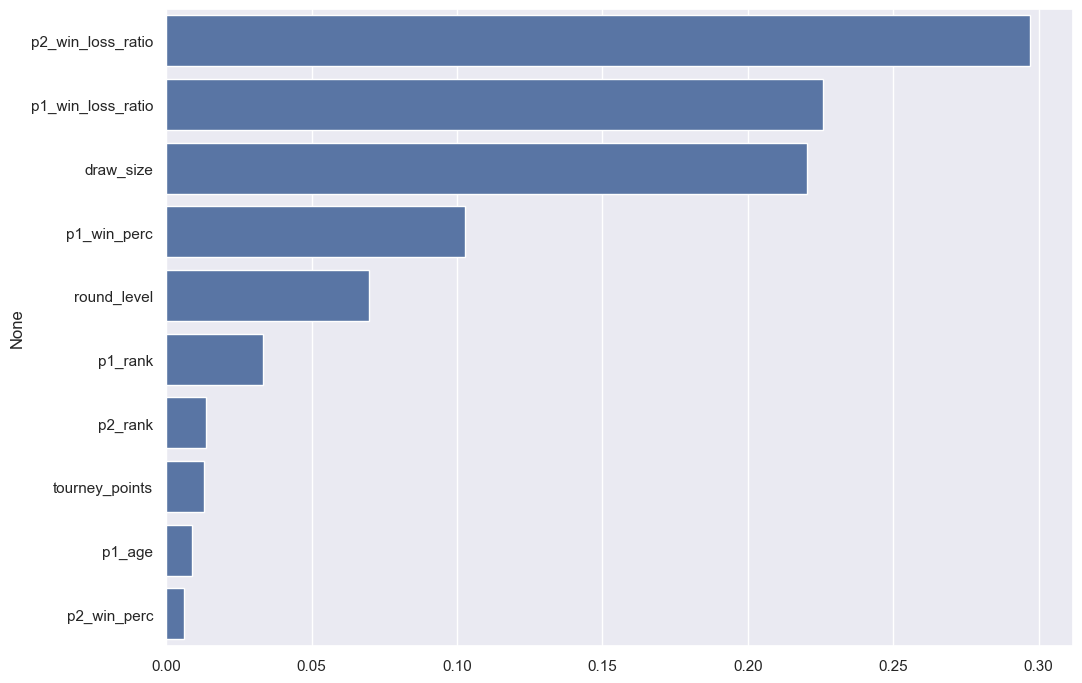

In [184]:
# Finally, we’ll visualize these values using a bar chart:

import seaborn as sns

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feat_importance.argsort()[::-1]
sorted_feature_names = tc.dataset_scaled.columns[sorted_indices]
sorted_importances = feat_importance[sorted_indices]

# Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x=sorted_importances[0:10],y=sorted_feature_names[0:10])
df = pd.DataFrame(sorted_importances,sorted_feature_names)
df.iloc[0:10]*100


In [ ]:
from matplotlib import pyplot as plt
from sklearn import tree
text_representation = tree.export_text(tc.model,show_weights=True,feature_names=tc.model.feature_names_in_)
print(text_representation)

# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(tc.model, 
#                    feature_names=tc.model.feature_names_in_,  
#                 #    class_names=tc.model.class_names,
#                    filled=True)

